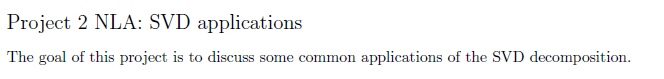

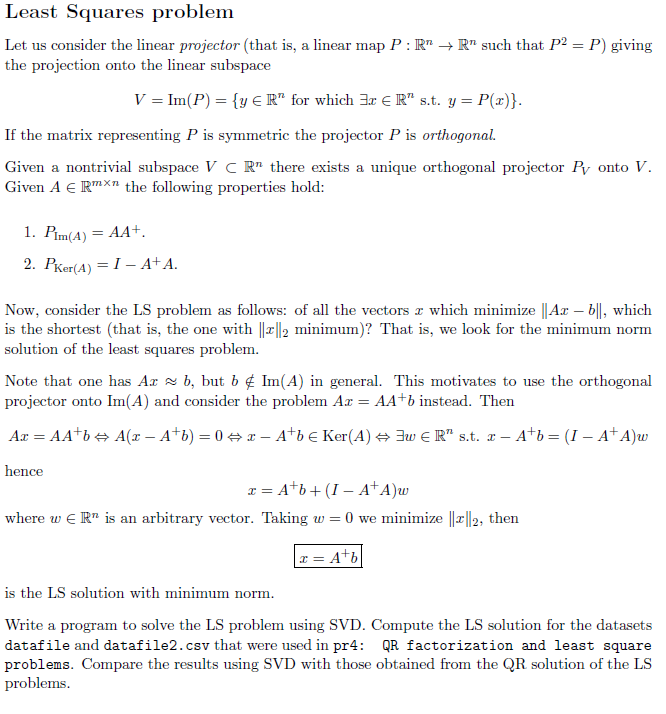

# Least Squares problem

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.linalg as sc

In [21]:
def load_data_task1():
    dades = pd.read_csv("dades.txt", header=None, sep="   ", engine="python").values
    A = dades[:, 0]
    b = dades[:, 1]
    return A, b


def load_data_task2():
    dades_regressio = pd.read_csv("dades_regressio.csv", header=None).values
    A = dades_regressio[:, :-1]
    b = dades_regressio[:, -1]
    return A, b


def plot_data1(A, solution, b):
    A_sorted, b_sorted = zip(*sorted(zip(A, b)))
    plt.plot(A_sorted, b_sorted)
    A_sorted, solution_sorted = zip(*sorted(zip(A, solution)))
    plt.plot(A_sorted, solution_sorted)
    plt.gcf().set_size_inches(2, 1)
    plt.show()


def generate_poly_matrix(A, dim):
    assert isinstance(dim, int)
    assert dim > 0
    return np.vstack([A ** d for d in range(dim)]).T


def least_squares_qr(A, b, plot=1):
    Q, R = np.linalg.qr(A)
    rank = min(R.shape)
    m, n = A.shape
    assert A.shape[0] == b.shape[0]
    assert A.shape[0] >= A.shape[1]
    y = Q.T @ b
    y1 = y[:n]
    y2 = y[n:]
    R1 = R[:n, :n]
    x = sc.solve_triangular(R1, y1)
    v = np.zeros(n - rank)
    x_qr = np.concatenate((x, v))
    if plot:
        plot_data1(A[:, 1], A @ x, b)
    return x_qr


def least_squares_svd(A, b, plot=1):
    U, S, V = np.linalg.svd(A, full_matrices=False)
    n = A.shape[1]
    S[S < 1e-5] = 0
    r = np.sum(S > 0)
    S = np.hstack([1 / S[:r], np.zeros(n - r)])
    A_plus = (V.T * S).dot(U.T)
    x_svd = A_plus.dot(b)
    if plot:
        plot_data1(A[:, 1], A @ x_svd, b)
    return x_svd

## Full Rank Matrix

Dim = 2


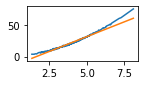

	Error SVD = 37.1146


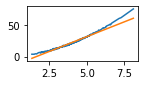

	Error QR = 37.1146
----------------------------------------
Dim = 3


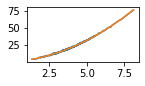

	Error SVD = 10.8808


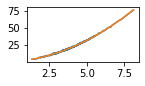

	Error QR = 10.8808
----------------------------------------
Dim = 4


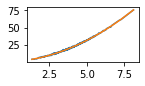

	Error SVD = 10.8805


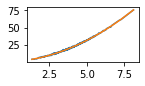

	Error QR = 10.8805
----------------------------------------


In [22]:
np.set_printoptions(precision=4, suppress=True)
A, b = load_data_task1()
for dim in range(2, 5):
    print("Dim =", dim)
    A_poly = generate_poly_matrix(A, dim)
    x_svd = least_squares_svd(A_poly, b)
    print("\tError SVD =", round(np.linalg.norm(A_poly.dot(x_svd) - b), 4))
    x_qr = least_squares_qr(A_poly, b)
    print("\tError QR =", round(np.linalg.norm(A_poly.dot(x_qr) - b), 4))
    print("-" * 40)

## Not Full Rank Matrix

In [23]:
A, b = load_data_task2()

x_svd = least_squares_svd(A, b, plot=0)
x_qr = least_squares_qr(A, b, plot=0)

print("Error SVD =", round(np.linalg.norm(A.dot(x_svd) - b), 4))
print("Error QR =", round(np.linalg.norm(A.dot(x_qr) - b), 4))

Error SVD = 1.2548
Error QR = 1.8051


# Graphics compression

---------------

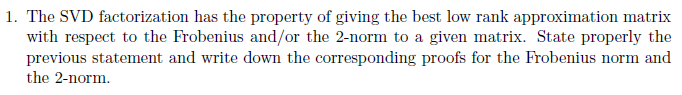

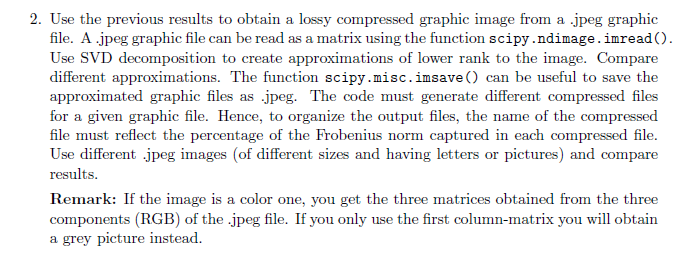

Image: sagrada , Size: 256 x 256
c: 1 error: 0.1266


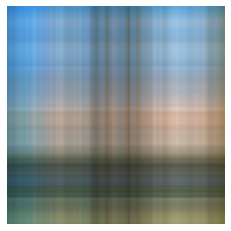

c: 4 error: 0.0493


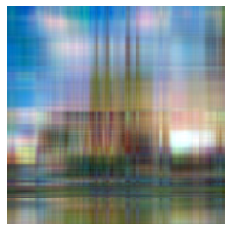

c: 10 error: 0.0251


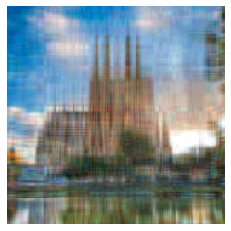

c: 30 error: 0.0103


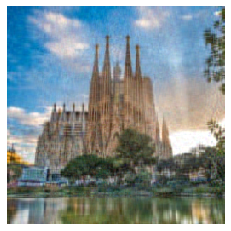

c: 100 error: 0.0023


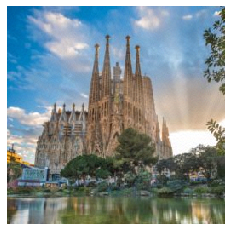

Image: cat , Size: 128 x 128
c: 1 error: 0.1402


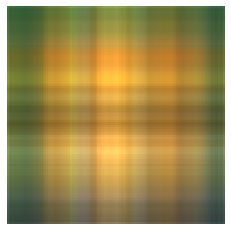

c: 4 error: 0.0648


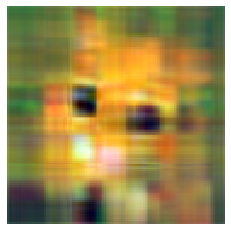

c: 10 error: 0.0286


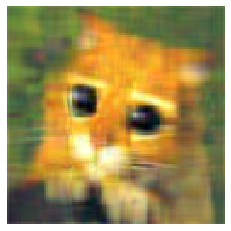

c: 30 error: 0.0089


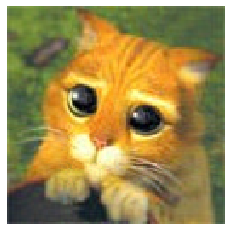

c: 100 error: 0.0003


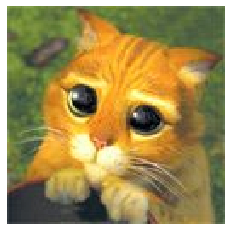

Image: gal , Size: 568 x 834
c: 1 error: 0.1857


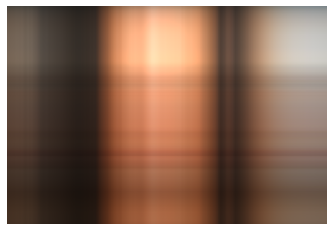

c: 4 error: 0.0455


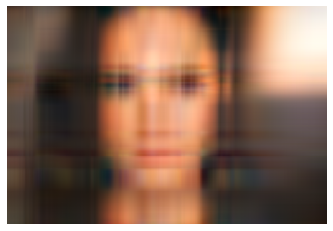

c: 10 error: 0.0177


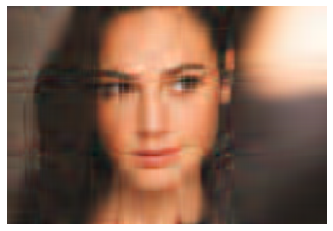

c: 30 error: 0.0044


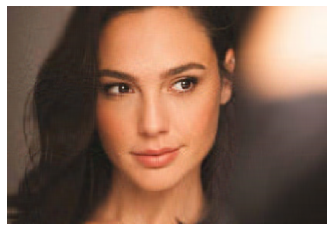

c: 100 error: 0.0009


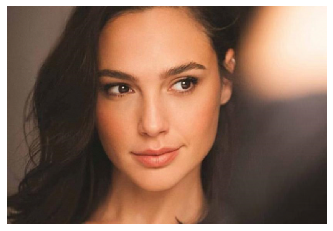

In [24]:
PNG_DIM = 4


def clip(img):
    img[img < 0] = 0
    img[img > 1] = 1
    return img


def compress(img, c):
    U, S, V = np.linalg.svd(img, full_matrices=False)
    img_compressed = U[:, :c] @ (np.diag(S[:c]) @ V[:c, :])
    error = np.linalg.norm(img - img_compressed, ord=2) / np.linalg.norm(img, ord=2)
    return img_compressed, error


def save_images(img, c, name):
    out_img = np.zeros(img.shape)
    total_error = 0
    for i in range(PNG_DIM):
        tmp_img, error = compress(img[:, :, i], c)
        out_img[:, :, i] = tmp_img
        total_error += error
    total_error = str(round(total_error / out_img.shape[2], 4))

    clipped_img = clip(out_img)
    print("c:", c, "error:", total_error)
    plt.imsave("compressed/" + name + "_" + total_error + ".png", clipped_img)
    plt.axis("off")
    plt.imshow(clipped_img)
    plt.show()


for name in ["sagrada", "cat", "gal"]:
    img = plt.imread("images/" + name + ".png")
    print("Image:", name, ", Size:", img.shape[0], "x", img.shape[1])
    for c in [1, 4, 10, 30, 100]:
        save_images(img, c, name)

# Principal Component Analysis

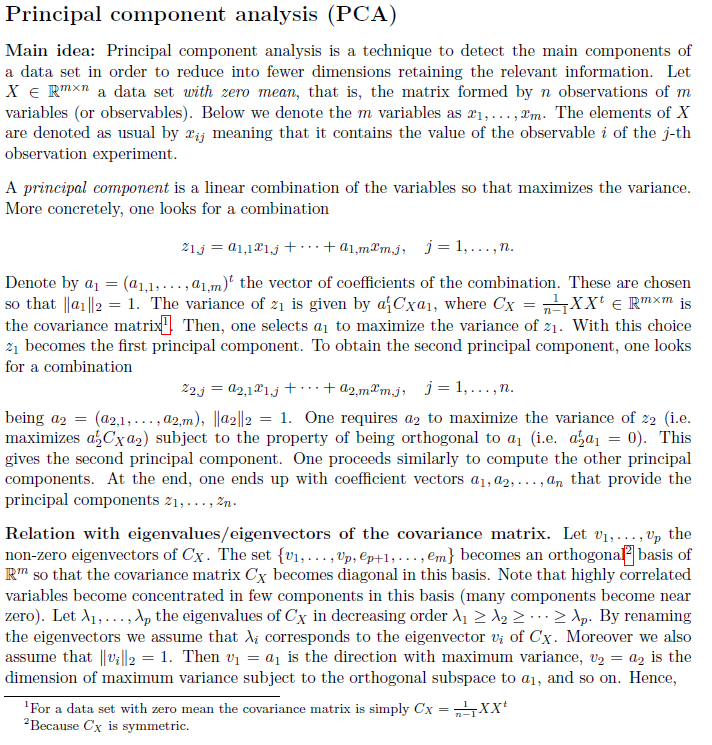


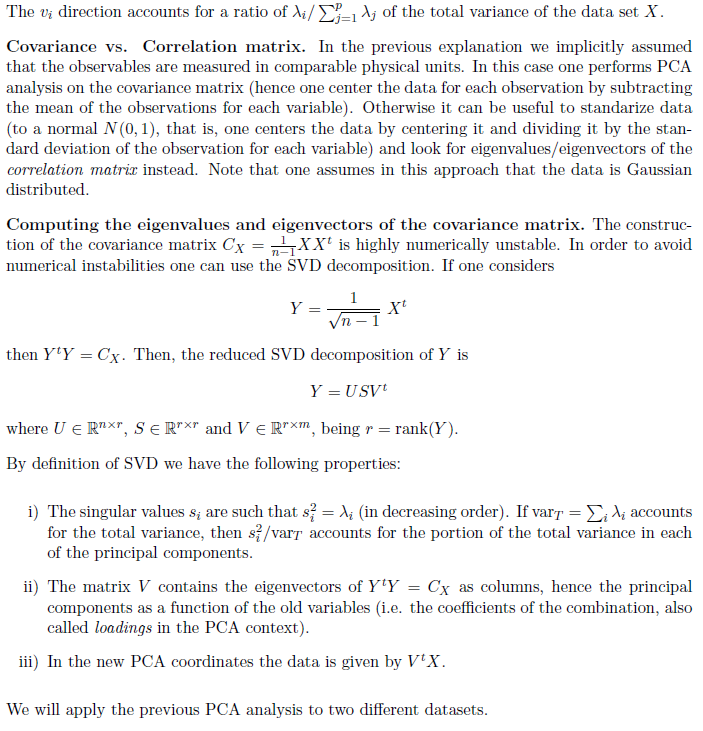

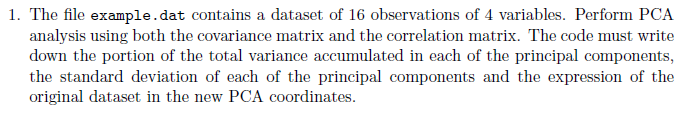

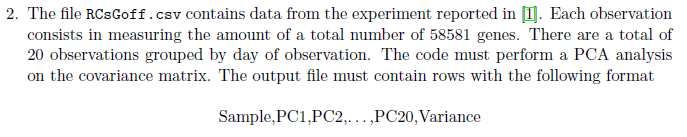

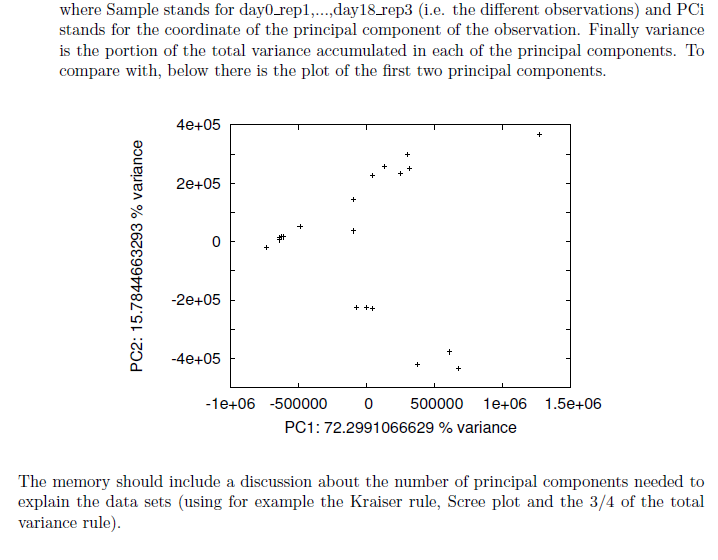

In [77]:
def pca_covariance(x, n=None):
    if n is None:
        n = x.shape[0]
    y = x.T / np.sqrt(n - 1)
    U, S, V = np.linalg.svd(y, full_matrices=False)
    S_pow = np.power(S, 2)
    return S_pow, V


def pca_correlation(x, n=None, transpose=False):
    if n is None:
        n = x.shape[0]
    std = np.std(x, axis=0)
    if transpose:
        x = x.T
    x = x / std
    return pca_cov(x, n)


def load_data_example():
    return pd.read_csv("example.dat", header=None, sep=" ", dtype=float).values


def load_data_RCsGoff():
    data = pd.read_csv("RCsGoff.csv")
    names = data.columns[1:].values
    data = data.iloc[:, 1:].values.T
    return data, names

In [78]:
X = load_data_example().T
s2, Vt = pca_correlation(X)
print(
    "Portion of the total variance accumulated in each of the principal components:",
    s2 / np.sum(s2),
)
print("Standard deviation of each of the principal components:", np.std(Vt, axis=0))
print("Standard deviation of each of the principal components:", np.std(Vt.T, axis=0))
pca_space = np.dot(Vt, X)
print(pca_space)


s2, Vt = pca_covariance(X, num)
print(
    "Portion of the total variance accumulated in each of the principal components:",
    s2 / np.sum(s2),
)
print("Standard deviation of each of the principal components:", np.std(Vt, axis=0))
print("Standard deviation of each of the principal components:", np.std(Vt.T, axis=0))
pca_space = np.dot(Vt, X)
print(pca_space)

Portion of the total variance accumulated in each of the principal components: [0.9411 0.0466 0.0093 0.003 ]
Standard deviation of each of the principal components: [0.4576 0.3448 0.4983 0.4165]
Standard deviation of each of the principal components: [0.0194 0.5    0.4997 0.5   ]
[[ -9.0254  -6.9845  -9.4676  -8.1417 -12.0398  -7.5179  -7.6415  -9.5086
  -10.4771  -7.9297 -10.5188 -12.5159  -8.4786  -9.4937  -8.5612  -9.404 ]
 [  2.0839   3.939    1.1353   2.8395   1.6414   2.8758   3.0601   1.5772
   -2.8603  -4.3518  -3.5598  -1.2911  -2.8461  -2.1331  -3.1038  -4.3013]
 [  0.0547   1.1044   1.42    -2.614   -0.5795   0.3407  -3.3329   0.1748
    0.6011   0.8187  -0.582   -0.6347   0.5298  -0.2379  -1.8986   2.0152]
 [ -0.443    0.6934  -0.2416  -1.6784   0.1189  -0.3076   0.3671   0.2609
   -0.8293   1.2295  -1.1595   0.5322  -0.8557   0.5124  -0.6834   0.0496]]
Portion of the total variance accumulated in each of the principal components: [0.8919 0.085  0.0182 0.0049]
Standard devi

Variance accumulated in each of the principal components: [0.723  0.1578 0.0669 0.0289 0.0123 0.0046 0.0036 0.0016 0.0004 0.0003
 0.0001 0.0001 0.0001 0.0001 0.0001 0.     0.     0.     0.     0.    ]


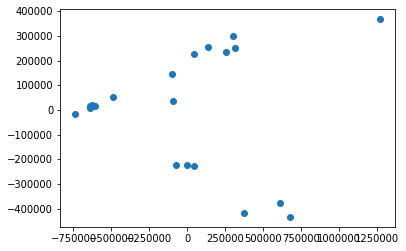

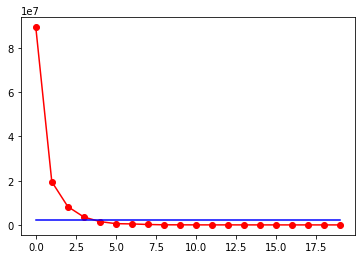

The number of principal components needed to explain the data sets:
Kraiser rule: 19, Scree plot: 4, 3/4 of the total variance rule: 1


In [79]:
X, sample_names = load_data_RCsGoff()

mean_arr = np.mean(X, axis=0)
X = X - mean_arr
X = X.T

num = 58581
s2, Vt = pca_covariance(X, num)

variance = s2 / np.sum(s2)
print("Variance accumulated in each of the principal components:", variance)
pca_space = np.dot(Vt, X)

plt.scatter(pca_space[0], pca_space[1])
plt.show()

scree_plot_treshold = 2000000
plt.plot(s2, "ro-")
plt.plot([scree_plot_treshold] * len(s2), "b-")
plt.show()

print("The number of principal components needed to explain the data sets:")
print(
    "Kraiser rule: {}, Scree plot: {}, 3/4 of the total variance rule: {}".format(
        sum(s2 > 1), sum(s2 > scree_plot_treshold), sum(variance > 0.75) + 1
    )
)

with open("output.txt", "w") as f:
    for idx, name in enumerate(sample_names):
        f.write(name)
        for elem in pca_space[idx]:
            f.write("," + str(elem))
        f.write(",{}\n".format(variance[idx]))